In [27]:
import torch                     # for all things PyTorch
import pandas as pd
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function
import numpy as np
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [28]:
class FlexibleMLP(nn.Module):
    def __init__(self, layers: list, scale: float = 1.0, bias_scale: float = 0.0, activation=nn.GELU()):
        """
        Initialize a customizable Multi-Layer Perceptron (MLP) with flexible architecture and initialization.

        Args:
            layers (list of int): A list of integers where each value defines the size of each layer.
                                  For example, layers=[10, 64, 32, 1] defines a network with input dimension 10,
                                  two hidden layers with sizes 64 and 32, and output dimension 1.
            scale (float): Scaling factor for weight initialization. Controls the standard deviation of
                           the normal distribution used in initializing weights. Recommended to be 1.0 for LeCun initialization.
            bias_scale (float): Scaling factor for bias initialization. Often set to 0.0 to start with no initial bias.
            activation (nn.Module): Activation function applied after each linear transformation except the last layer.
                                    Defaults to nn.GELU(), but can be any activation like nn.ReLU(), nn.Tanh(), etc.
        """
        # Call the constructor of the parent class (nn.Module) to initialize all internal PyTorch machinery.
        # This is crucial because nn.Module handles a lot of behind-the-scenes logic like:
        # - registering parameters (weights and biases) for automatic optimization
        # - setting up .to(device), .eval(), .train(), etc.
        # - tracking submodules (layers, activations, etc.)
        #
        # If you omit this line, the module will NOT work correctly in PyTorch:
        # things like model.cuda(), model.parameters(), model.state_dict(), etc. will all break.
        #
        # The super() call here:
        # - FlexibleMLP is our class
        # - nn.Module is the parent class
        # - self.__init__() is the method we want to call from the parent
        super(FlexibleMLP, self).__init__()

        # Save arguments as attributes for reuse in reset_parameters
        self.layer_sizes = layers
        self.scale = scale
        self.bias_scale = bias_scale
        self.activation_fn = activation

        # Create containers to hold layers and activations
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        # Build network structure (but not weights yet)
        self._build_layers()

        # Initialize weights and biases
        self.reset_parameters()

    def _build_layers(self):
        """
        Build the linear layers and corresponding activations (except for initialization).
        """
        for i in range(len(self.layer_sizes) - 1):
            # Create a linear layer from layer i to layer i+1
            layer = nn.Linear(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.layers.append(layer)

            # Add an activation function unless it's the final layer
            if i < len(self.layer_sizes) - 2:
                self.activations.append(self.activation_fn)
            else:
                # Final layer doesn't use activation (use Identity to keep list structure consistent)
                self.activations.append(nn.Identity())

    def reset_parameters(self):
        """
        Apply custom initialization to all layers using the given scale and bias_scale.
        """
        for i, layer in enumerate(self.layers):
            # Apply LeCun-style initialization for better gradient behavior
            nn.init.normal_(layer.weight, mean=0.0, std=self.scale * np.sqrt(1 / self.layer_sizes[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=self.bias_scale * np.sqrt(1 / self.layer_sizes[i]))

    def forward(self, x, return_last_hidden=False):
        """
        Perform a forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
            return_last_hidden (bool): If True, returns both the final output and the last hidden layer's output.
                                       Useful for feature extraction, analysis, or interpretability.

        Returns:
            torch.Tensor: Output of the final layer.
            torch.Tensor (optional): Output of the last hidden layer (before final linear layer),
                                     if return_last_hidden is set to True.
        """
        last_hidden = None  # Will store the output of the last hidden layer

        # Apply all but the last layer with activation
        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))  # Apply linear transformation and activation
            last_hidden = x  # Save the last hidden output

        # Final layer (linear transformation only, no activation)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x


In [29]:
def set_seed(seed_value=42):
    """
    Set random seed across NumPy, Python, and PyTorch to ensure reproducibility.

    Args:
        seed_value (int): The seed value to use. Default is 42, a commonly used arbitrary number.

    This function ensures that experiments produce the same results across different runs,
    which is critical for debugging, comparing models, and scientific reproducibility.

    It sets the seed for:
        - NumPy (used for numerical ops like matrix generation)
        - Python's built-in random module (used in random sampling, shuffling, etc.)
        - PyTorch (both CPU and GPU)

    For GPU reproducibility:
        - It manually sets the CUDA seeds (for single and multi-GPU setups)
        - It disables the CUDA backend benchmarking feature to ensure deterministic behavior
          (at the potential cost of performance).
    """

    # Set seed for NumPy (used in data shuffling, batch generation, etc.)
    np.random.seed(seed_value)

    # Set seed for PyTorch operations on CPU
    torch.manual_seed(seed_value)

    # Set seed for Python's built-in random module (e.g., random.shuffle, random.randint)
    random.seed(seed_value)

    # Set seeds for PyTorch operations on GPU
    if torch.cuda.is_available():
        # Set seed for single-GPU
        torch.cuda.manual_seed(seed_value)

        # Set seed for all available GPUs (multi-GPU training)
        torch.cuda.manual_seed_all(seed_value)

        # Ensures that CUDA uses deterministic algorithms
        # This disables non-deterministic optimizations and ensures reproducible behavior
        torch.backends.cudnn.deterministic = True

        # Disables cuDNN auto-tuner which selects the best algorithm for each configuration
        # When disabled, it uses deterministic algorithms, but this might make training slower
        torch.backends.cudnn.benchmark = False

# Set the seed globally so every run starts from the same state
set_seed(42)


In [30]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

def prepare_lagged_mlp_data(df: pd.DataFrame, symbol: str, max_lag: int = 10, test_size: float = 0.8, seed: int = 42):
    """
    Prepare lagged feature matrix and binary (0/1) classification target from stock returns,
    and split into PyTorch-ready training and test sets. Also returns test set raw returns
    for strategy evaluation.

    Args:
        df (pd.DataFrame): must contain ['SYMBOL', 'DATE', 'TIME', 'RETURN']
        symbol (str): asset to process
        max_lag (int): number of lagged returns as features
        test_size (float): fraction of data to allocate to test set
        seed (int): random seed for reproducibility

    Returns:
        train_loader, test_loader: PyTorch DataLoader objects
        input_dim: int, number of input features (should be max_lag)
        test_returns: np.ndarray of raw returns (not labels) aligned with test set
    """
    group = df[df['SYMBOL'] == symbol].sort_values(by=['DATE', 'TIME']).reset_index(drop=True)
    returns = group['RETURN'].values.astype(np.float32)

    if len(returns) < max_lag + 1:
        raise ValueError("Not enough data to build lagged features.")

    # Build lagged features (X), binary targets (y), and raw next-step returns (y_raw)
    X = np.column_stack([returns[i:len(returns)-max_lag+i] for i in range(max_lag)])
    y_raw = returns[max_lag:]  # actual returns (not labels)
    y = np.where(y_raw > 0, 1.0, 0.0).astype(np.float32)

    # Split data (same split applies to y_raw)
    X_train, X_test, y_train, y_test, y_raw_train, y_raw_test = train_test_split(
        X, y, y_raw, test_size=test_size, random_state=seed, shuffle=False
    )

    # Standardize features
    X_scaler = StandardScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Wrap in datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, X.shape[1], y_raw_test  # <--- Added test_returns


In [31]:
df=pd.read_parquet('/Users/emanueledurante/Desktop/LGMB/lausanne/epfl/MLfinance/High-Frequency-Trading-with-Deep-Learning/data/high_10m.parquet')
symbol = 'GS'
input_dim = 10
train_loader, test_loader, input_dim,test_returns = prepare_lagged_mlp_data(df, symbol, max_lag=input_dim)

model = FlexibleMLP([input_dim, 64, 32, 32, 32, 1], scale=1.0, bias_scale=0.0)
#model = FlexibleMLP([input_dim, 64, 32, 1], scale=1.0, bias_scale=0.0)


In [32]:
set_seed(42)  # Fixing the seed
criterion = nn.BCEWithLogitsLoss()  #For prediction, MSE is the standard objective; but other, custom objective might be better;
# choose loss appropriate for your task
# experiment with learning rates, lr = 0.02, 0.01, 0.001
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # this is one of the most popular gradient descent algorithms
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # experiment with 0.1, 0.2, 0.5. 0.5 is super interesting, achives well OOS!!!

In [33]:
set_seed(42)  # Fixing the seed
import torch.optim as optim
# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Training loop

# careful, for minibatch 32, 400 is enough!!!
num_epochs = 10000  # You might need more epochs for a deep network
losses = []
cool_loss = []
for epoch in range(num_epochs):
    # now we loop through the mini-batches
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs) # this is f(x;\theta)
        loss = criterion(outputs, targets) # this is \sum_{t\in mini batch} \ell(y_t, f(x_t;\theta))

        # Backward and optimize
        optimizer.zero_grad() # forget the gradients from old steps of Gradient Descent (GD)
        loss.backward() # compute the new gradient, \nabla_\theta L(\theta)
        optimizer.step() # \theta_{k+1}=\theta_k - \eta \nabla_\theta L(\theta_k).
        losses.append(loss.item())

    cool_loss.append(np.mean(losses))
    losses = []
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg train loss: {np.mean(cool_loss):.6f}")

Epoch [1/10000] Avg train loss: 0.705851
Epoch [2/10000] Avg train loss: 0.706066
Epoch [3/10000] Avg train loss: 0.705019
Epoch [4/10000] Avg train loss: 0.705278
Epoch [5/10000] Avg train loss: 0.704731
Epoch [6/10000] Avg train loss: 0.704229
Epoch [7/10000] Avg train loss: 0.704280
Epoch [8/10000] Avg train loss: 0.703355
Epoch [9/10000] Avg train loss: 0.703361
Epoch [10/10000] Avg train loss: 0.703508
Epoch [11/10000] Avg train loss: 0.702430
Epoch [12/10000] Avg train loss: 0.702199
Epoch [13/10000] Avg train loss: 0.702052
Epoch [14/10000] Avg train loss: 0.701357
Epoch [15/10000] Avg train loss: 0.701097
Epoch [16/10000] Avg train loss: 0.700827
Epoch [17/10000] Avg train loss: 0.700355
Epoch [18/10000] Avg train loss: 0.699728
Epoch [19/10000] Avg train loss: 0.699481
Epoch [20/10000] Avg train loss: 0.699353
Epoch [21/10000] Avg train loss: 0.698996
Epoch [22/10000] Avg train loss: 0.698513
Epoch [23/10000] Avg train loss: 0.698212
Epoch [24/10000] Avg train loss: 0.698019
E

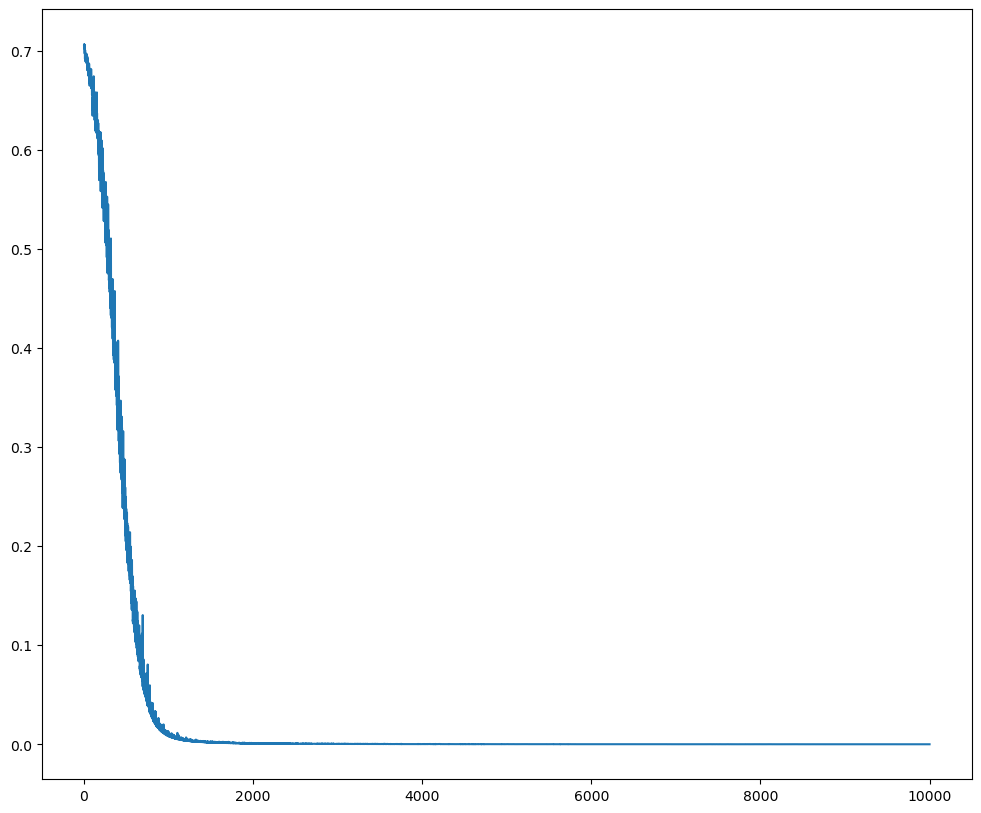

In [34]:
import matplotlib.pyplot as plt
plot_e = np.linspace(1,  10000, num= 10000)

plt.figure(figsize=(12, 10))
plt.plot(plot_e, np.array(cool_loss))



Training metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000

Test metrics:
  Accuracy:  0.5159
  Precision: 0.5238
  Recall:    0.3976
  F1 Score:  0.4521


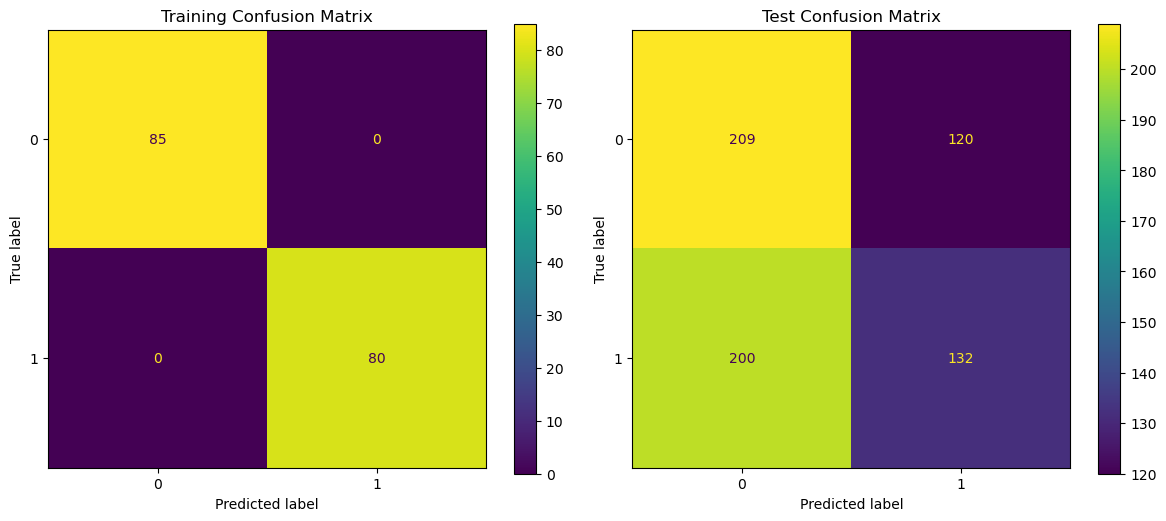

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to eval mode
model.eval()

# Prediction function
def get_predictions(loader):
    targets = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            targets.extend(labels.numpy())
            predictions.extend(preds.numpy())

    return np.array(targets).flatten(), np.array(predictions).flatten()

# Get predictions
train_targets, train_preds = get_predictions(train_loader)
test_targets, test_preds = get_predictions(test_loader)

# Metrics
def print_metrics(y_true, y_pred, label='Set'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n{label} metrics:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

print_metrics(train_targets, train_preds, label='Training')
print_metrics(test_targets, test_preds, label='Test')

# Confusion Matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

train_cm = confusion_matrix(train_targets, train_preds)
test_cm = confusion_matrix(test_targets, test_preds)

ConfusionMatrixDisplay(train_cm, display_labels=[0, 1]).plot(ax=axs[0], values_format='d')
axs[0].set_title("Training Confusion Matrix")

ConfusionMatrixDisplay(test_cm, display_labels=[0, 1]).plot(ax=axs[1], values_format='d')
axs[1].set_title("Test Confusion Matrix")

plt.tight_layout()
plt.show()


Test classification accuracy: 51.59%
99% CI under null: [46.58%, 56.60%] — Significant? NO


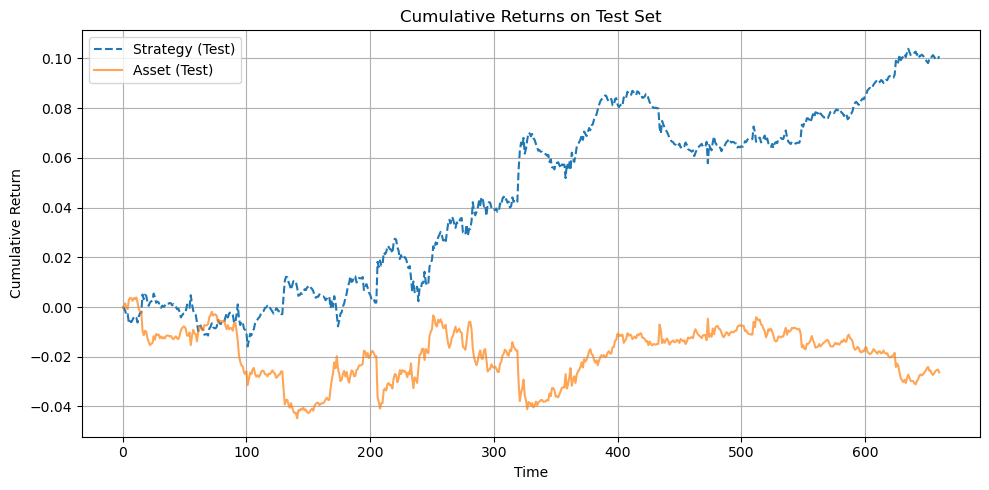

In [36]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

# === 1. CLASSIFICATION ACCURACY (TEST ONLY) ===
test_accuracy = np.mean(test_targets == test_preds)

# === 1.1. Confidence interval around 0.5 (null hypothesis) ===
n_test = len(test_targets)
p_hat = test_accuracy
p_0 = 0.5
z = norm.ppf(1 - 0.01 / 2)  # two-tailed 99% CI → z ≈ 2.576
se = np.sqrt(p_0 * (1 - p_0) / n_test)
ci_low = p_hat - z * se
ci_high = p_hat + z * se
significant = "YES" if ci_low > 0.5 else "NO"

print(f"Test classification accuracy: {test_accuracy:.2%}")
print(f"99% CI under null: [{ci_low:.2%}, {ci_high:.2%}] — Significant? {significant}")

# === 2. STRATEGY RETURNS (TEST ONLY) ===
# Map prediction: 1 → long (+1), 0 → short (-1)
# test_preds: binary predicted labels (0 = short, 1 = long)
# test_returns: actual returns aligned with the test set (same shape)

# Convert predictions into trading signals: 1 → long, 0 → short (mapped to +1 / -1)
test_signals = 2 * test_preds - 1  # now in {-1, +1}

# Compute strategy returns
test_strategy_returns = test_signals * test_returns

# Plot cumulative returns
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(np.cumsum(test_strategy_returns), label='Strategy (Test)', linestyle='--')
ax.plot(np.cumsum(test_returns), label='Asset (Test)', alpha=0.7)

ax.set_title('Cumulative Returns on Test Set')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
